Total energy now contains local density-density interactions

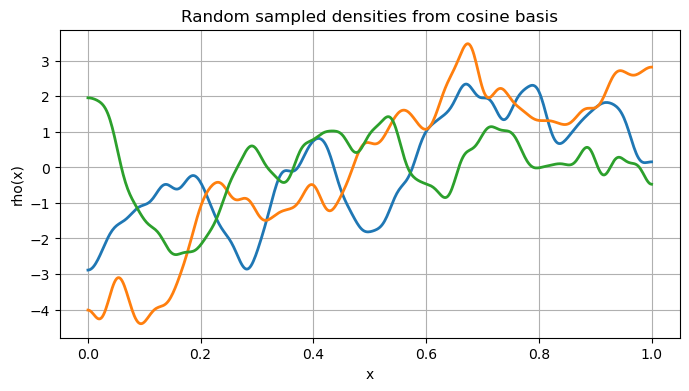

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import math, os, time, copy
import torch.fft as tfft
import pandas as pd
import torch_dct as dct
from numpy import size
from ewaldnn1d import *
from ewaldnn2d.feat_utils import generate_data_2d

torch.random.manual_seed(1234) # for reproducibility

# Global settings
dtype = torch.float64
device = "cpu"

data_regime = "smooth" # "smooth" or "rough"

N_grid = 512 # number of grid points
if data_regime == "smooth":
    M_cutoff = 50 # maximum harmonic
    m = torch.arange(1, M_cutoff+1, dtype=dtype, device=device)             # (M,)
    x = torch.linspace(0, 1, N_grid, dtype=dtype, device=device)            # (N,)
    #design matrix needed to sample densities
    DesignMatrix = torch.cos(torch.pi * torch.outer(m, x))                  # (M, N)
    DerDM = -torch.pi * m[:, None] * torch.sin(torch.pi * torch.outer(m, x))  # (M, N) # derivative of design matrix
    std_harm = 2.0 / (1.0 + 0.2 * m)**2 # std_harm = 2.0 / (1.0 + m)**2
elif data_regime == "rough":
    M_cutoff = N_grid - 1 # maximum harmonic
    m = torch.arange(1, M_cutoff+1, dtype=dtype, device=device)             # (M,)
    x = torch.linspace(0, 1, N_grid, dtype=dtype, device=device)            # (N,)
    #design matrix needed to sample densities
    DesignMatrix = torch.cos(torch.pi * torch.outer(m, x))                  # (M, N)
    DerDM = -torch.pi * m[:, None] * torch.sin(torch.pi * torch.outer(m, x))  # (M, N) # derivative of design matrix
    std_harm = 2.0 / (1.0 + 0.0 * m)**2
else:
    raise ValueError("regime must be 'smooth' or 'rough'")

N_train = 1500
N_test = 250
N_val = 250
N_batch = 50
N_epochs = 10000
lr = 1e-2 # we will use a LR scheduler, so this is just an initial value
min_delta = 1e-5 # min change in the monitored quantity to qualify as an improvement
patience = 30    # epochs to wait for improvement before stopping training'
pad_mode = "zero" # padding mode for convolution-based routines: either "zero" or "reflect"
N_feat = 1 # number of local features per grid point

# interaction kernel parameters
kernel_regime = "double_Gaussian" # "single_Gaussian" or "double_Gaussian" 
if kernel_regime == "single_Gaussian":
    amp_Gaussian = 1.0 # amplitude of Gaussian kernel for interaction energy
    sigma_Gaussian = 3.0 # width of Gaussian kernel for interaction energy
elif kernel_regime == "double_Gaussian":
    amp_Gaussian_1 = -1.0 # amplitude of first Gaussian kernel for interaction energy
    sigma_Gaussian_1 = 3.0 # width of first Gaussian kernel for interaction energy
    amp_Gaussian_2 = 2.0 # amplitude of second Gaussian kernel for interaction energy
    sigma_Gaussian_2 = 1.0 # width of second Gaussian kernel for interaction energy
else:
    raise ValueError("Here kernel_regime must be 'single_Gaussian' or 'double_Gaussian'")

# define total energy function
if kernel_regime == "single_Gaussian":
    def E_tot(rho: torch.Tensor) -> torch.Tensor:
        return amp_Gaussian * E_int_conv(rho, kernel="gaussian", sigma=sigma_Gaussian, pad_mode=pad_mode)
elif kernel_regime == "double_Gaussian":
    def E_tot(rho: torch.Tensor) -> torch.Tensor:
        return (amp_Gaussian_1 * E_int_conv(rho, kernel="gaussian", sigma=sigma_Gaussian_1, pad_mode=pad_mode) +
                amp_Gaussian_2 * E_int_conv(rho, kernel="gaussian", sigma=sigma_Gaussian_2, pad_mode=pad_mode))

# generate train/test split
rho_train, d_rho_train, a_train = sample_density_batch(N_train, std_harm=std_harm, DesignMatrix=DesignMatrix, DerDM=DerDM)  # (N_train, N_grid)
rho_test, d_rho_test, a_test = sample_density_batch(N_test, std_harm=std_harm, DesignMatrix=DesignMatrix, DerDM=DerDM)   # (N_test, N_grid)
rho_val, d_rho_val, a_val = sample_density_batch(N_val, std_harm=std_harm, DesignMatrix=DesignMatrix, DerDM=DerDM)    # (N_val, N_grid)
features_train = generate_loc_features_rs(rho_train, N_feat=N_feat)  # (N_train, N_grid, N_feat)
features_test  = generate_loc_features_rs(rho_test, N_feat=N_feat)   # (N_test, N_grid, N_feat)
features_val   = generate_loc_features_rs(rho_val, N_feat=N_feat)    # (N_val, N_grid, N_feat)

targets_train = E_tot(rho_train)            # (N_train,)
targets_test  = E_tot(rho_test)             # (N_test,)
targets_val   = E_tot(rho_val)              # (N_val,)

# Normalize features
mean_feat, std_feat = compute_normalization_stats(features_train)
features_train_norm = normalize_features(features_train, mean_feat, std_feat)
features_test_norm = normalize_features(features_test, mean_feat, std_feat)
features_val_norm = normalize_features(features_val, mean_feat, std_feat)

# Normalize targets
E_mean = targets_train.mean()
E_std = targets_train.std()
targets_train_norm = (targets_train - E_mean) / E_std
targets_test_norm = (targets_test - E_mean) / E_std
targets_val_norm = (targets_val - E_mean) / E_std

# Datasets
train_dataset = TensorDataset(features_train_norm, targets_train_norm)
val_dataset   = TensorDataset(features_val_norm,   targets_val_norm)
test_dataset  = TensorDataset(features_test_norm,  targets_test_norm)

# Loaders
train_loader = DataLoader(train_dataset, batch_size=N_batch, shuffle=True,  drop_last=False)
val_loader   = DataLoader(val_dataset,   batch_size=N_batch, shuffle=False, drop_last=False)
test_loader  = DataLoader(test_dataset,  batch_size=N_batch, shuffle=False, drop_last=False)


N_batch = 20
rho_batch, _, a_batch = sample_density_batch(N_batch, std_harm=std_harm, DesignMatrix=DesignMatrix, DerDM=DerDM)
plt.figure(figsize=(8,4))
plt.plot(x.numpy(), rho_batch[0, :].numpy(), lw=2)
plt.plot(x.numpy(), rho_batch[1, :].numpy(), lw=2)
plt.plot(x.numpy(), rho_batch[2, :].numpy(), lw=2)
plt.xlabel("x")
plt.ylabel("rho(x)")
plt.title("Random sampled densities from cosine basis")
plt.grid(True)
plt.show()

# For saving data used in Figure 1
# np.savetxt("Figure_1/rho_batch_" + data_regime + ".txt", rho_batch.cpu().numpy())
# R = 25
# C_avg_analytical = ((std_harm**2).unsqueeze(1) * C_mm(m, torch.arange(-R, R+1), N_grid)).sum(dim=0)
# r_vals = torch.arange(-R, R+1)
# data = np.column_stack([r_vals.cpu().numpy(), C_avg_analytical.cpu().numpy()])
# np.savetxt("Figure_1/C_avg_" + data_regime + ".txt", data)
# C = dens_dens_corr_func(rho_batch, R)
# np.savetxt("Figure_1/C_batch_" + data_regime + ".txt", C.cpu().numpy())

Density-density correlation function analysis

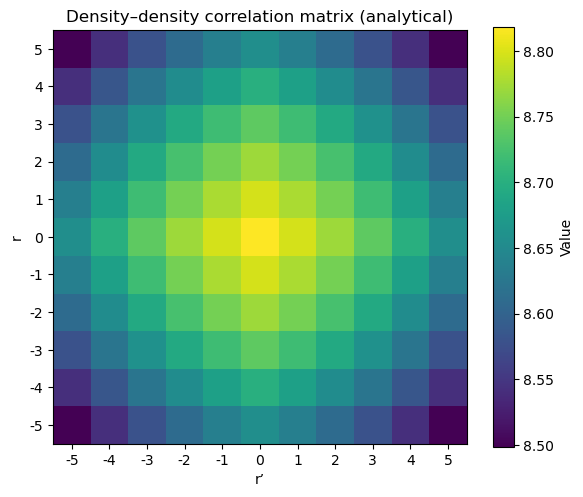

In [2]:
# Analytical calculation of the correlation matrix
R = 5
C_avg_analytical = ((std_harm**2).unsqueeze(1) * C_mm(m, torch.arange(-R, R+1), N_grid)).sum(dim=0)
M_analytical = second_moment_analytical(m, R, N_grid, std_harm)
flag_zero = True

# Visualize the correlation matrix 
if data_regime == "rough" and flag_zero:
    M_analytical[R, R] = 0.0
M_analytical = M_analytical.detach().cpu().numpy()
plt.figure(figsize=(6,5))
plt.imshow(M_analytical, origin='lower', cmap='viridis', aspect='equal')
plt.colorbar(label="Value")
r_vals = torch.arange(-R, R+1)
r_vals = r_vals.cpu().numpy()
ticks = np.arange(len(r_vals))
plt.xticks(ticks, r_vals)
plt.yticks(ticks, r_vals)
plt.xlabel("r’")
plt.ylabel("r")
plt.title("Density–density correlation matrix (analytical)")
plt.tight_layout()
plt.show()


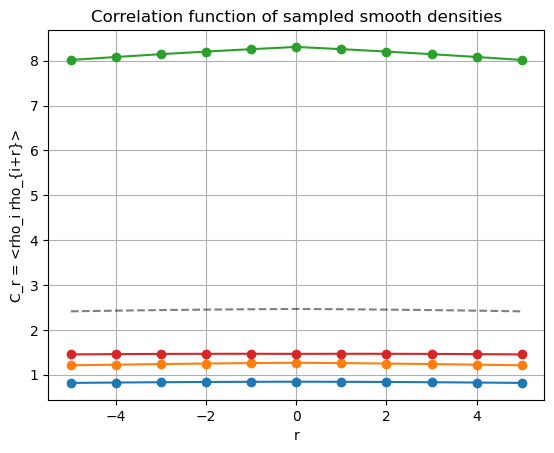

Eigenspectrum: tensor([5.0325e+01, 8.6394e-04, 7.5196e-06, 3.9635e-09, 8.9344e-12, 5.8099e-15],
       dtype=torch.float64)
Learned kernel vector: tensor([ 1.0879, -0.4318,  0.0955, -1.2971,  0.5044, -0.2940],
       dtype=torch.float64)


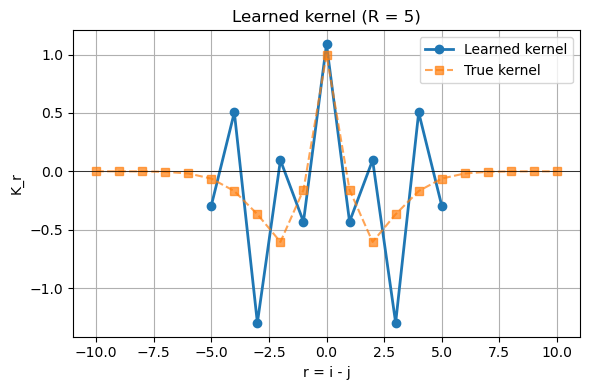

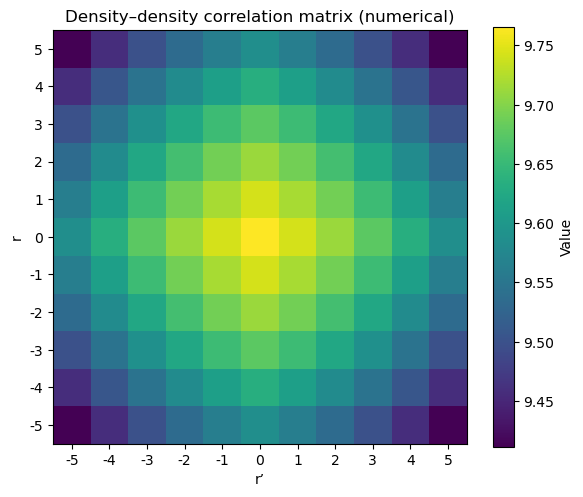

Max relative difference between numerical and analytical C(r): 0.012431335731050819
Max relative difference between numerical and analytical correlation matrix: 0.009938817950205974


In [3]:
# Numerical estimation of the correlation matrix
N_cycles = 1
N_batch = 1000
C_mat = torch.zeros((N_batch, 2*R+1), dtype=dtype, device=device)
M = torch.zeros((2*R+1, 2*R+1), dtype=dtype, device=device)
for _ in range(N_cycles):

    rho_batch, d_rho_batch, a_batch = sample_density_batch(N_batch, std_harm=std_harm, DesignMatrix=DesignMatrix, DerDM=DerDM)  # (B, N)
    Eng_batch = E_tot(rho_batch)  # (B,)

    C = dens_dens_corr_func(rho_batch, R)  # (B, 2R+1)
    C_mat += C  # (B, 2R+1)
    M += C.T @ C  # (2R+1, 2R+1)

C_avg = C_mat.sum(dim=0) / (N_batch * N_cycles)
M = M / (N_batch * N_cycles)

r_vals = torch.arange(-R, R+1)
plt.plot(r_vals.cpu(), C_mat[0,:].cpu(), 'o-')
plt.plot(r_vals.cpu(), C_mat[1,:].cpu(), 'o-')
plt.plot(r_vals.cpu(), C_mat[2,:].cpu(), 'o-')
plt.plot(r_vals.cpu(), C_mat[3,:].cpu(), 'o-')
plt.plot(r_vals.cpu(), C_avg_analytical.cpu(), 'k--', label="Average (analytical)", alpha=0.5)
plt.xlabel("r")
plt.ylabel("C_r = <rho_i rho_{i+r}>")
if data_regime == "smooth":
    plt.title("Correlation function of sampled smooth densities")
else:
    plt.title("Correlation function of sampled rough densities")
plt.grid(True)
plt.show()


# Analyze the eigenspectrum
C_symm_mat = dens_dens_corr_func_sym(rho_batch, R)  # (B, R+1)
G = C_symm_mat.T @ C_symm_mat / N_batch  # (R+1, R+1)
U, S, Vt = torch.svd(G) 
print("Eigenspectrum:", S)

# Compute the kernel vector (linear regression) and compare to the true kernel
g = (C_symm_mat.T @ Eng_batch) / N_batch
k_star = torch.linalg.solve(G, g)
print("Learned kernel vector:", k_star)
k_learned = make_symmetric(k_star)
R_max = 10
r_grid = torch.arange(-R_max, R_max+1)
if kernel_regime == "single_Gaussian":
    k_true = amp_Gaussian * K_gaussian(r_grid, sigma=sigma_Gaussian)
elif kernel_regime == "double_Gaussian":
    k_true = (amp_Gaussian_1 * K_gaussian(r_grid, sigma=sigma_Gaussian_1) +
              amp_Gaussian_2 * K_gaussian(r_grid, sigma=sigma_Gaussian_2))
else:
    raise ValueError("Here kernel_regime must be 'single_Gaussian' or 'double_Gaussian'")
plt.figure(figsize=(6,4))
plt.plot(torch.arange(-R, R+1), k_learned , 'o-', label='Learned kernel', linewidth=2)
plt.plot(r_grid, k_true, 's--', label='True kernel', alpha=0.7)
plt.axhline(0, color='k', linewidth=0.5)
plt.xlabel("r = i - j")
plt.ylabel("K_r")
plt.title(f"Learned kernel (R = {R})")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Visualize the correlation matrix 
if data_regime == "rough" and flag_zero:
    M[R, R] = 0.0
M = M.detach().cpu().numpy()
plt.figure(figsize=(6,5))
plt.imshow(M, origin='lower', cmap='viridis', aspect='equal')
plt.colorbar(label="Value")
r_vals = torch.arange(-R, R+1)
r_vals = r_vals.cpu().numpy()
ticks = np.arange(len(r_vals))
plt.xticks(ticks, r_vals)
plt.yticks(ticks, r_vals)
plt.xlabel("r’")
plt.ylabel("r")
plt.title("Density–density correlation matrix (numerical)")
plt.tight_layout()
plt.show()

print("Max relative difference between numerical and analytical C(r):", np.max(np.abs(C_avg.detach().cpu().numpy() - C_avg_analytical.detach().cpu().numpy()))/np.linalg.norm(C_avg_analytical.detach().cpu().numpy()) )
print("Max relative difference between numerical and analytical correlation matrix:", np.max(np.abs(M - M_analytical))/np.linalg.norm(M_analytical) )

Training

In [15]:
flag_train = False # set to True to train models
learning_regime = "gaussmixt" # "window" or "gaussmixt"
ckpt_dir = "LearningLocalKernel_checkpoints"
R_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
n_components_list = [1, 2, 3, 4, 5, 6, 7]
if flag_train:
    if learning_regime == "window":
        for R in R_list:

            run_name = f"loc_window_kernel_{R}_" + data_regime + '_' + kernel_regime
            torch.manual_seed(1234) # for reproducibility

            model = KernelOnlyEnergyNN(
                R=R, 
                pad_mode=pad_mode,
                mean_feat=mean_feat,
                std_feat=std_feat,
                E_mean=E_mean,
                E_std=E_std,
            ).to(device)
            
            optimizer = optim.Adam(model.parameters(), lr=lr)
            criterion = nn.MSELoss()

            # Reduce LR when val loss plateaus
            scheduler = optim.lr_scheduler.ReduceLROnPlateau(
                optimizer, mode='min', factor=0.5, patience=patience, cooldown=2, min_lr=1e-6
            )


            hist, best_epoch = train_with_early_stopping(
                model=model,
                train_loader=train_loader,
                val_loader=val_loader,
                criterion=criterion,
                optimizer=optimizer,
                scheduler=scheduler,
                max_epochs=N_epochs,
                patience=patience,
                min_delta=min_delta,
                ckpt_dir=ckpt_dir,
                run_name=run_name,
                learning_regime=learning_regime,
                N_grid=N_grid,
                device=device,
            )

    elif learning_regime == "gaussmixt":

        for n_components in n_components_list:
                
            run_name = f"loc_gaussmix_kernel_{n_components}_" + data_regime + '_' + kernel_regime
            torch.manual_seed(1234) # for reproducibility

            model = GaussianMixtureEnergyNN(
                R=40,
                n_components=n_components,
                pad_mode=pad_mode,
                mean_feat=mean_feat,
                std_feat=std_feat,
                E_mean=E_mean,
                E_std=E_std,
            ).to(device)

            
            optimizer = optim.Adam(model.parameters(), lr=lr)
            criterion = nn.MSELoss()

            # Reduce LR when val loss plateaus
            scheduler = optim.lr_scheduler.ReduceLROnPlateau(
                optimizer, mode='min', factor=0.5, patience=patience, cooldown=2, min_lr=1e-6
            )

            hist, best_epoch = train_with_early_stopping(
                model=model,
                train_loader=train_loader,
                val_loader=val_loader,
                criterion=criterion,
                optimizer=optimizer,
                scheduler=scheduler,
                max_epochs=N_epochs,
                patience=patience,
                min_delta=min_delta,
                ckpt_dir=ckpt_dir,
                run_name=run_name,
                learning_regime=learning_regime,
                N_grid=N_grid,
                device=device,
            )

amplitudes: tensor([-0.0603, -0.0655, -0.0766])
sigmas    : tensor([0.9533, 3.9442, 8.9857])
   epoch  train_loss  val_loss
0      1    0.345707  0.056131
1      2    0.010564  0.000824
2      3    0.000341  0.000131
3      4    0.000054  0.000029
4      5    0.000031  0.000032


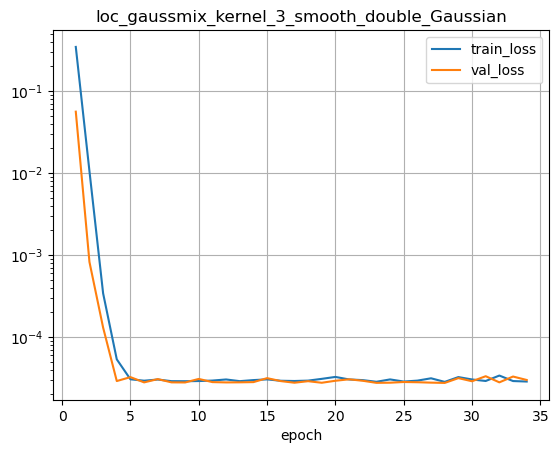

In [ ]:
if learning_regime == "window":
    R = 10
    run_name = f"loc_window_kernel_{R}_" + data_regime + '_' + kernel_regime
elif learning_regime == "gaussmixt":
    n_components = 3
    run_name = f"loc_gaussmix_kernel_{n_components}_" + data_regime + '_' + kernel_regime
    model, normalization, epoch, val_loss = load_checkpoint(ckpt_dir + f"/{run_name}_best.pt", GaussianMixtureEnergyNN, device=device)
    with torch.no_grad():
        amps   = model.kernel_conv.amplitudes.detach().cpu()
        sigmas = F.softplus(model.kernel_conv.log_sigmas).detach().cpu()
        print("amplitudes:", amps)
        print("sigmas    :", sigmas)


path = ckpt_dir + f"/{run_name}_history.csv"
hist_df = pd.read_csv(path)
print(hist_df.head())
hist_df.plot(x="epoch", y=["train_loss", "val_loss"], logy=True, grid=True, title=run_name)


# # For saving data used in Figure 1
# epochs = hist_df["epoch"].to_numpy()
# train_loss = hist_df["train_loss"].to_numpy()
# val_loss = hist_df["val_loss"].to_numpy()
# data = np.column_stack([epochs, train_loss, val_loss])
# # np.savetxt(f"Figure_1/window_history_R{R}_{data_regime}_{kernel_regime}.txt", data)
# np.savetxt(f"Figure_1/gaussmixt_history_n{n_components}_{data_regime}_{kernel_regime}.txt", data)



Model loc_gaussmix_kernel_1_smooth_double_Gaussian: best val loss = 0.000243 at epoch 6
Best model: n_components=1, val_loss=0.000243
Model loc_gaussmix_kernel_2_smooth_double_Gaussian: best val loss = 0.000104 at epoch 4
Best model: n_components=2, val_loss=0.000104
Model loc_gaussmix_kernel_3_smooth_double_Gaussian: best val loss = 0.000029 at epoch 4
Best model: n_components=3, val_loss=0.000029
Model loc_gaussmix_kernel_4_smooth_double_Gaussian: best val loss = 0.000023 at epoch 85
Best model: n_components=4, val_loss=0.000023
Model loc_gaussmix_kernel_5_smooth_double_Gaussian: best val loss = 0.000011 at epoch 41
Best model: n_components=5, val_loss=0.000011
Model loc_gaussmix_kernel_6_smooth_double_Gaussian: best val loss = 0.000017 at epoch 21
Best model: n_components=5, val_loss=0.000011
Model loc_gaussmix_kernel_7_smooth_double_Gaussian: best val loss = 0.000010 at epoch 40
Best model: n_components=7, val_loss=0.000010
Validation history:
n_components=1: val_loss=0.000243
n_co

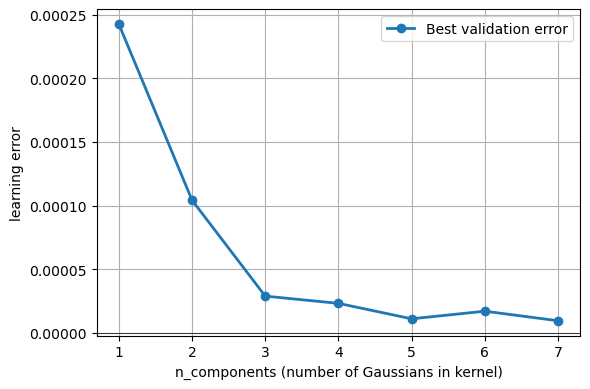

In [16]:
if learning_regime == "window":
    R_best = 0
    best_val = math.inf

    val_hist_R = []
    learning_hist_R = []

    for R in R_list:
        run_name = f"loc_window_kernel_{R}_" + data_regime + '_' + kernel_regime

        model, normalization, epoch, val_loss = load_checkpoint(ckpt_dir + f"/{run_name}_best.pt", KernelOnlyEnergyNN, device=device)

        val_hist_R.append((R, val_loss))
        learning_hist_R.append((R, ))

        print(f"Model {run_name}: best val loss = {val_loss:.6f} at epoch {epoch}")
        if val_loss < best_val:
            best_val = val_loss
            R_best = R

        print(f"Best model: R={R_best}, val_loss={best_val:.6f}")

    print("Validation history:")
    for R, val_loss in val_hist_R:
        print(f"R={R}: val_loss={val_loss:.6f}")

    plt.figure(figsize=(6,4))
    plt.plot([x[0] for x in val_hist_R], [x[1] for x in val_hist_R], 'o-', label='Best validation error', linewidth=2)
    plt.axhline(0, color='k', linewidth=0.5)
    plt.xlabel("R (kernel range)")
    plt.ylabel("learning error")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
elif learning_regime == "gaussmixt":
    n_components_best = 0
    best_val = math.inf

    val_hist_n = []
    learning_hist_n = []

    for n in n_components_list:
        run_name = f"loc_gaussmix_kernel_{n}_" + data_regime + '_' + kernel_regime
        model, normalization, epoch, val_loss = load_checkpoint(ckpt_dir + f"/{run_name}_best.pt", GaussianMixtureEnergyNN, device=device)

        val_hist_n.append((n, val_loss))
        learning_hist_n.append((n, ))

        print(f"Model {run_name}: best val loss = {val_loss:.6f} at epoch {epoch}")
        if val_loss < best_val:
            best_val = val_loss
            n_components_best = n

        print(f"Best model: n_components={n_components_best}, val_loss={best_val:.6f}")

    print("Validation history:")
    for n, val_loss in val_hist_n:
        print(f"n_components={n}: val_loss={val_loss:.6f}")

    plt.figure(figsize=(6,4))
    plt.plot([x[0] for x in val_hist_n], [x[1] for x in val_hist_n], 'o-', label='Best validation error', linewidth=2)
    plt.axhline(0, color='k', linewidth=0.5)
    plt.xlabel("n_components (number of Gaussians in kernel)")
    plt.ylabel("learning error")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

Evaluate performance of training

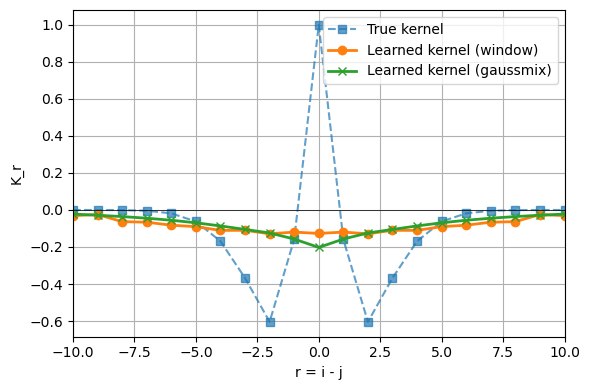

In [7]:
flag_window = True # set to True to visualize window-based kernel
flag_gaussmix = True # set to True to visualize gaussmixt-based kernel

R = 10
n_components = 3
# Original true kernel
r_grid = np.arange(-R, R+1)
if kernel_regime == "single_Gaussian":
    def K_true(r):
        return amp_Gaussian * np.exp(-(r**2) / (sigma_Gaussian**2))
elif kernel_regime == "double_Gaussian":
    def K_true(r):
        return (amp_Gaussian_1 * np.exp(-(r**2) / (sigma_Gaussian_1**2)) +
                amp_Gaussian_2 * np.exp(-(r**2) / (sigma_Gaussian_2**2)))
k_true = K_true(r_grid)

if flag_window:
    run_name = f"loc_window_kernel_{R}_" + data_regime + '_' + kernel_regime
    model, normalization, epoch, val_loss = load_checkpoint(ckpt_dir + f"/{run_name}_best.pt", KernelOnlyEnergyNN, device=device)
    with torch.no_grad():
        k_full = model.kernel_conv.build_kernel().view(-1).cpu().numpy() 
if flag_gaussmix:
    run_name = f"loc_gaussmix_kernel_{n_components}_" + data_regime + '_' + kernel_regime
    model, normalization, epoch, val_loss = load_checkpoint(ckpt_dir + f"/{run_name}_best.pt", GaussianMixtureEnergyNN, device=device)  
    with torch.no_grad():
        r_grid_gm = model.kernel_conv.r_vals.cpu().numpy()       # shape (2R+1,)
        k_full_gm = model.kernel_conv.build_kernel().view(-1).cpu().numpy()


plt.figure(figsize=(6,4))
plt.plot(r_grid, k_true, 's--', label='True kernel', alpha=0.7)
if flag_window:
    plt.plot(r_grid, k_full , 'o-', label='Learned kernel (window)', linewidth=2)
if flag_gaussmix:
    plt.plot(r_grid_gm, k_full_gm , 'x-', label='Learned kernel (gaussmix)', linewidth=2)
plt.axhline(0, color='k', linewidth=0.5)
plt.xlabel("r = i - j")
plt.ylabel("K_r")
plt.xlim(-R, R)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# For saving data used in Figure 1
# data = np.column_stack([r_grid, k_true, k_full])
# np.savetxt("Figure_1/kernels_window_" + data_regime + ".txt", data)
# data = np.column_stack([r_grid_gm, k_full_gm])
# np.savetxt("Figure_1/kernels_gaussmix_" + data_regime + ".txt", data)

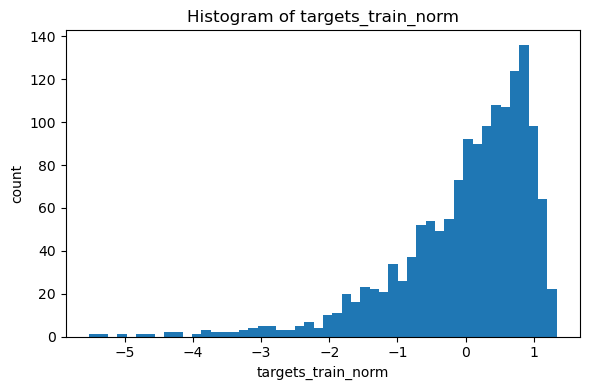

In [8]:
targets_train_norm

plt.figure(figsize=(6,4))
plt.hist(targets_train_norm, bins=50)
plt.xlabel("targets_train_norm")
plt.ylabel("count")
plt.title("Histogram of targets_train_norm")
plt.tight_layout()
plt.show()

In [9]:
if learning_regime == "window":
# energy from the learned window kernel
    def E_int_conv_discrete(rho: torch.Tensor,
                            k_full: torch.Tensor,
                            R: int) -> torch.Tensor:
        """
        Interaction energy with a finite-range kernel k_full of length 2R+1.
        rho: (N,) or (B, N)
        k_full: (2R+1,)  -- symmetric kernel [K_-R, ..., K_0, ..., K_R]
        R: kernel range
        Returns: (B,) energy
        """
        if rho.dim() == 1:
            rho = rho.unsqueeze(0)  # (1, N)
        B, N = rho.shape
        device, dtype = rho.device, rho.dtype

        k_full = k_full.to(device=device, dtype=dtype)          # (2R+1,)
        weight = k_full.view(1, 1, -1)                          # (1, 1, 2R+1)

        # pad by R on each side for linear convolution with kernel of size 2R+1
        u = F.conv1d(rho.unsqueeze(1), weight, padding=R).squeeze(1)  # (B, N)

        E = 0.5 * (rho * u).sum(dim=-1) / N  # (B,)
        return E.squeeze(0) if E.numel() == 1 else E

    N_batch = 5
    rho_batch, _, _ = sample_density_batch(N_batch, std_harm=std_harm, DesignMatrix=DesignMatrix, DerDM=DerDM)  # (B, N_grid)

    if kernel_regime == "single_Gaussian":
        E_int_batch = amp_Gaussian * E_int_conv(rho_batch, kernel="gaussian", sigma=sigma_Gaussian)
        E_int_batch_discrete = E_int_conv_discrete(rho_batch, model.kernel_conv.build_kernel().view(-1), R=model.R)
    elif kernel_regime == "double_Gaussian":
        E_int_batch = (amp_Gaussian_1 * E_int_conv(rho_batch, kernel="gaussian", sigma=sigma_Gaussian_1) +
                    amp_Gaussian_2 * E_int_conv(rho_batch, kernel="gaussian", sigma=sigma_Gaussian_2))
        E_int_batch_discrete = E_int_conv_discrete(rho_batch, model.kernel_conv.build_kernel().view(-1), R=model.R)
    E_int_batch_discrete = E_int_conv_discrete(rho_batch, model.kernel_conv.build_kernel().view(-1), R=model.R)
    print("E_int_batch:", E_int_batch)
    print("E_int_batch_discrete:", E_int_batch_discrete)

E_int_batch: tensor([-2.2935, -1.6646, -1.5011, -1.7175, -2.8709], dtype=torch.float64)
E_int_batch_discrete: tensor([-2.2752, -1.6597, -1.4990, -1.7090, -2.8686], dtype=torch.float64,
       grad_fn=<DivBackward0>)
